In [1]:
import os
import sys
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train = np.argmax(y_train, axis=1)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]


y_train = tf.keras.utils.to_categorical(y_train, 10)

x_train_reshape = [x_train[i].reshape((784)) for i in range(len(x_train))]
print(np.array(x_train_reshape).shape)

x_test_reshape = [x_test[i].reshape((784)) for i in range(len(x_test))]
print(np.array(x_test_reshape).shape)

(60000, 784)
(10000, 784)


In [5]:
n_hidden_neurons = 256
lr = 0.001
epochs = 40 # clusterability paper uses 40 epochs. 20 training, 20 training with pruning
batch_size = 128
limit = (batch_size * (len(x_train) // batch_size)) # number of training examples to use. Must be multiple of batch_size
test_limit = (batch_size * (len(x_test) // batch_size)) # Must be multiple of batch_size
alpha = 1.0 # penalise polysemantic neurons.

In [6]:
sys.path.insert(0, '../clusterability_in_neural_networks/')
from src import spectral_cluster_model, train_nn

/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.h

In [7]:
i_save = tf.keras.layers.Input(shape=(28*28,))
e1_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i_save)
e2_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_2')(e1_save)
e3_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_3')(e2_save)
e4_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_4')(e3_save)
o_save = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e4_save)
model_save = tf.keras.Model(inputs=i_save, outputs=o_save)
# for i,layer in enumerate(model.layers[:5]):
#     print(layer)
#     model_save.layers[i].set_weights(layer.get_weights())
# model_save.save_weights('./mnist_penalise_polysemantic_neurons_all_classes_clusterability_weights.h5')
model_save.load_weights('./mnist_baseline_all_classes_clusterability_weights.h5')

2022-06-05 08:38:52.020641: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-05 08:38:52.037088: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ffc2cf142f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-05 08:38:52.037124: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [8]:
weights = [w for w in model_save.get_weights() if len(w.shape)==2] # skip biases
print(weights[-1].shape)
adj_mat = spectral_cluster_model.weights_to_graph(weights)

(256, 10)


In [9]:
adj_mat

<1818x1818 sparse matrix of type '<class 'numpy.float64'>'
	with 799744 stored elements in Compressed Sparse Row format>

(-0.5, 1817.5, 1817.5, -0.5)

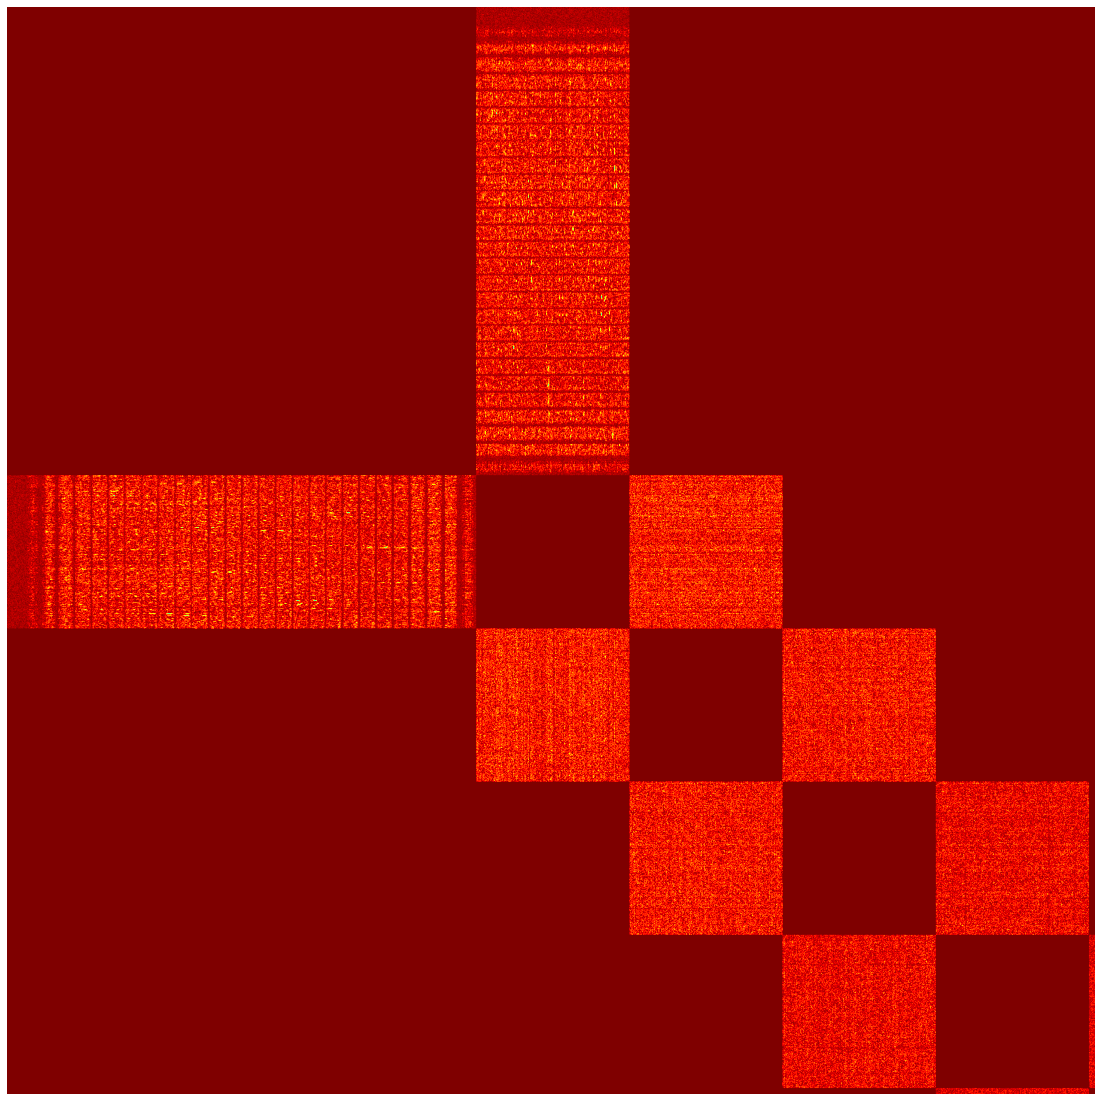

In [10]:
fig=plt.figure(figsize=(20,20))
plt.imshow(adj_mat.toarray(), cmap='jet_r')
plt.axis('off')

In [11]:
clustering_labels = spectral_cluster_model.cluster_net(12, adj_mat, 'arpack', assign_labels='kmeans')

/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = n

/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = n

/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = n

/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = n

In [12]:
clustering_labels

array([8, 8, 8, ..., 6, 6, 6], dtype=int32)

In [13]:
clustering_labels.shape

(1818,)

In [14]:
model_save.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
softmax (Dense)              (None, 10)                2570      
Total params: 400,906
Trainable params: 400,906
Non-trainable params: 0
_______________________________________________________

In [15]:
784+256+256+256+256+10

1818

In [16]:
cca = spectral_cluster_model.connected_comp_analysis(weights, adj_mat)

In [17]:
cca

{'num_comps': 1,
 'counts_dict': {1818: 1},
 'prop_each_layer': array([0., 0., 0., 0., 0., 0.])}